In [1]:
import copy
import numpy as np
import pandas
import os
import json
import itertools

import csv
import pandas as pd

import matplotlib.pyplot as plt
from parameters import *
import sys
sys.path.append('..')

from utils.helpers import *


def split_length(total_length, max_length):
    '''
    Split a float / int into a list with max_length
    '''
    print('total_length = ' + str(total_length) + ' max_length = ' + str(max_length))
    if total_length <= max_length:
        output = [total_length]
    else:
        floor = int(total_length // max_length)
        remaining = (total_length - floor * max_length)
        output = [max_length] * floor
        if remaining != 0:
            output += [remaining]
    print('output = ' + str(output))
    return(output)


def split_list(input_list, max_length):
    '''
    Split a list into a list of lists with max_length
    '''
    length_list = split_length(len(input_list), max_length)
    output = []
    start_id = 0
    for le in length_list:
        output += [input_list[start_id: start_id + le]]
        start_id += le
    print('splitlist first value len = ' + str(len(output[0])))
    return(output)


import concurrent.futures as cf
import multiprocessing

try:
    from tqdm import tqdm
    imported_tqdm = True
except (ImportError, ModuleNotFoundError):
    imported_tqdm = False


def parallel_run(func,
                 run_list,
                 n_workers,
                 func_args=(),
                 func_kwargs={},
                 input_as_kwargs=False,
                 processor_no_limited=False,
                 use_tqdm=False,
                 thread_pool=False):
    '''
    Parameters
    ----------
    func                    : function
    run_list                : list
    n_workers               : int
    func_args               : tuple, optional
    func_kwargs             : dict, optional
    input_as_kwargs         : {True, False (default)}, optional
    processor_no_limited    : {True, False (default)}, optional
    use_tqdm                : {True, False (default)}, optional
    thread_pool             : {True, False (default)}, optional
    '''
    run_list_t = run_list

    if processor_no_limited:
        n_workers_use = min(multiprocessing.cpu_count(), n_workers)
    else:
        n_workers_use = n_workers
    n_workers_use = min(n_workers, len(run_list_t))

    u_tqdm = False
    if use_tqdm:
        if imported_tqdm:
            u_tqdm = True
        else:
            warnings.warn('\'tqdm\' not installed.')

    retry_id_list = []
    if n_workers_use == 1:
        if u_tqdm:
            if input_as_kwargs:
                result = [func(*func_args, **x, **func_kwargs)
                          for x in tqdm(run_list_t)]
            else:
                result = [func(x, *func_args, **func_kwargs)
                          for x in tqdm(run_list_t)]
        else:
            if input_as_kwargs:
                result = [func(*func_args, **x, **func_kwargs)
                          for x in run_list_t]
            else:
                result = [func(x, *func_args, **func_kwargs)
                          for x in run_list_t]
    else:
        if not thread_pool:
            ex = cf.ProcessPoolExecutor(max_workers=n_workers_use)
        else:
            ex = cf.ThreadPoolExecutor(max_workers=n_workers_use)

        if input_as_kwargs:
            job_list = [ex.submit(func, *func_args, **x, **func_kwargs)
                        for x in run_list_t]
        else:
            job_list = [ex.submit(func, x, *func_args, **func_kwargs)
                        for x in run_list_t]

        if u_tqdm:
            tqdm_kwargs = {
                'total': len(job_list),
                'unit_scale': True
            }
            for f in tqdm(cf.as_completed(job_list), **tqdm_kwargs):
                pass
        ex.shutdown(wait=True)

        result = [0] * len(job_list)
        for j, job in enumerate(job_list):
            try:
                result[j] = job.result()
            except Exception as e:
                msg = 'item ' + str(j) + ' with error: ' + str(e)
                raise RuntimeError(msg)
    return(result)


title_fontsize=24
label_fontsize=22
legend_fontsize=20
tick_fontsize = 22

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
def get_xgate_fidelity(
    x, y, 
    config_template=CONFIG_TEMPLATE_JSON, 
    pulse_data_path='/tmp/xgate.csv',
    output_objf_path='/tmp/xgate_fidelity.csv',
    cleanup=True, 
    verbose=False):
    
    BASE_DIR = '../'
      
    with open(pulse_data_path, 'w') as f:
        writer = csv.writer(f)
        writer.writerows(pd.concat([pd.DataFrame(y), pd.DataFrame(x)], axis=1).values)
    
    if verbose:
        !cd $BASE_DIR && julia check_RX_pulse_objective_function.jl \
            --config_path $config_template \
            --pulse_data_path $pulse_data_path \
            --output_objf_path $output_objf_path
    else:
        !cd $BASE_DIR && julia check_RX_pulse_objective_function.jl \
            --config_path $config_template \
            --pulse_data_path $pulse_data_path \
            --output_objf_path $output_objf_path > /dev/null

    fidelity_data =  1 - pd.read_csv(output_objf_path, header=None).abs()
    
    if cleanup:
        !rm -f $pulse_data_path
        !rm -f $output_objf_path
    
    return fidelity_data

In [3]:
def get_fidelity(csv_path, n_workers=1, max_length = 10000, tmp_dir = '/tmp', original = True):
    pulse_d = pandas.read_csv(csv_path)#, header=None)
    if original:
        n_para = 20
        y_values = pulse_d.iloc[:, 0:n_para].to_numpy()
        x_values = pulse_d.iloc[:, n_para:].to_numpy()
        print('in original')
        print(y_values)
        print(x_values)
        x_values_split = split_list(x_values, max_length)
        y_values_split = split_list(y_values, max_length)
    else:
        n_para = 5
        y_values = pulse_d.iloc[:, 0:n_para].to_numpy()
        x_values = pulse_d.iloc[:, n_para:].to_numpy()
        print('in NOT original')
        print(y_values)
        print(x_values)
        x_values_split = split_list(x_values, max_length)
        y_values_split = split_list(recover_original_structure(y_values), max_length)
    run_list = []
    for j, val_in in enumerate(zip(x_values_split, y_values_split)):
        x, y = val_in
        run_list.append(dict(
            x=x,
            y=y,
            pulse_data_path=os.path.join(tmp_dir, 'xgate_{j}.csv'.format(j=j)),
            output_objf_path=os.path.join(tmp_dir, 'xgate_fidelity_{j}.csv'.format(j=j)))
        )
    #print(run_list)
    fidelities_raw_list = parallel_run(
        func=get_xgate_fidelity,
        run_list=run_list,
        n_workers=n_workers,
        input_as_kwargs=True,
        use_tqdm=True)
    fidelities_list = [fr.to_numpy().transpose()[0] for fr in fidelities_raw_list]
    fidelities = np.hstack(fidelities_list)

    angles = x_values
    return angles, fidelities

In [4]:
csv_paths = [
    'new_df.csv',
    '/local/ml4qcontrol/data_pulse/xrotation/D1_10_Pmin_200/rx_test_configfile_config_template_D1_10_Pmin_200.json_randomseed_0001.csv'
]

angles_list = []
fidelities_list = []
for csv_path in csv_paths:
    if csv_path == 'new_df.csv':
        original = False
    else:
        original = True
    angles, fidelities = get_fidelity(csv_path, n_workers=32, max_length=40000, tmp_dir='/tmp', original=original)
    
    angles_list.append(angles)
    fidelities_list.append(fidelities)

in NOT original
[[ 0.00361307 -0.00438222 -0.01543153 -0.00624184  0.00553576]
 [ 0.00358037 -0.00438458 -0.01541874 -0.00630024  0.00556107]
 [ 0.00354096 -0.0043894  -0.01540488 -0.00636081  0.00557835]
 ...
 [-0.00295909  0.00389094  0.01549874  0.00598681 -0.00512811]
 [-0.0029812   0.00387073  0.01551585  0.00590967 -0.00508752]
 [-0.00300471  0.00385357  0.01553178  0.00583891 -0.00505042]]
[[-3.14159265]
 [-3.1400583 ]
 [-3.13852394]
 ...
 [ 3.13852394]
 [ 3.1400583 ]
 [ 3.14159265]]
total_length = 4096 max_length = 40000
output = [4096]
splitlist first value len = 4096
total_length = 4096 max_length = 40000
output = [4096]
splitlist first value len = 4096


100%|██████████| 1/1 [00:37<00:00, 37.08s/it]


in original
[[ 4.69229392e-03 -6.08998618e-03 -1.64629020e-02 ... -3.95258436e-05
   1.41143708e-03  3.09169063e-04]
 [ 1.50374685e-03 -7.89687689e-03 -1.00316390e-02 ... -1.14220840e-03
  -8.71234147e-04 -1.36680529e-04]
 [ 6.31954278e-03 -2.55002514e-03 -1.53036277e-02 ... -3.93741294e-05
   1.14494222e-03  4.61116863e-04]
 ...
 [-3.08617699e-03  3.16073759e-03  1.53677928e-02 ...  5.98160872e-04
  -1.92137618e-03 -4.36286112e-04]
 [-4.08503840e-03  1.93348249e-03  1.53438255e-02 ...  1.20175491e-03
  -2.07177840e-03 -6.14818138e-04]
 [-3.58621641e-03  2.62796750e-03  1.55577059e-02 ...  1.52985928e-03
  -4.57331329e-04 -1.95698187e-04]]
[[-3.1400583 ]
 [-3.13852394]
 [-3.13698959]
 ...
 [ 3.13852394]
 [ 3.1400583 ]
 [ 3.14159265]]
total_length = 4095 max_length = 40000
output = [4095]
splitlist first value len = 4095
total_length = 4095 max_length = 40000
output = [4095]
splitlist first value len = 4095


100%|██████████| 1/1 [00:36<00:00, 36.67s/it]


In [5]:
title_fontsize=24
label_fontsize=22
legend_fontsize=20
tick_fontsize = 22

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [6]:
data_id = 0

In [7]:
np.mean(fidelities_list[data_id])

0.9999716770131285

In [8]:
low_fid_count = 0
bad_fidelities_list = []
bad_angles_list = []
new_fidelities_list = []
new_angles_list = []

# Iterate over each file's data
for file_idx, fidelities in enumerate(fidelities_list):
    angles = angles_list[file_idx]  # Corresponding angles for this file
    
    # Iterate over the fidelity values and corresponding angles
    for idx, fidelity in enumerate(fidelities):
        if fidelity < 0.999:
            bad_fidelities_list.append(fidelity)
            bad_angles_list.append(angles[idx])
            low_fid_count += 1
        if angles[idx] < 3.1:
            new_fidelities_list.append(fidelity)
            new_angles_list.append(angles[idx])

new_angles_list = np.array(new_angles_list)


In [9]:
def flatten(l):
    return [item for sublist in l for item in sublist]

/tmp/ipykernel_27485/1213427866.py:33: RuntimeWarning: invalid value encountered in divide
  f_aver_list = f_aver_list / counter_list


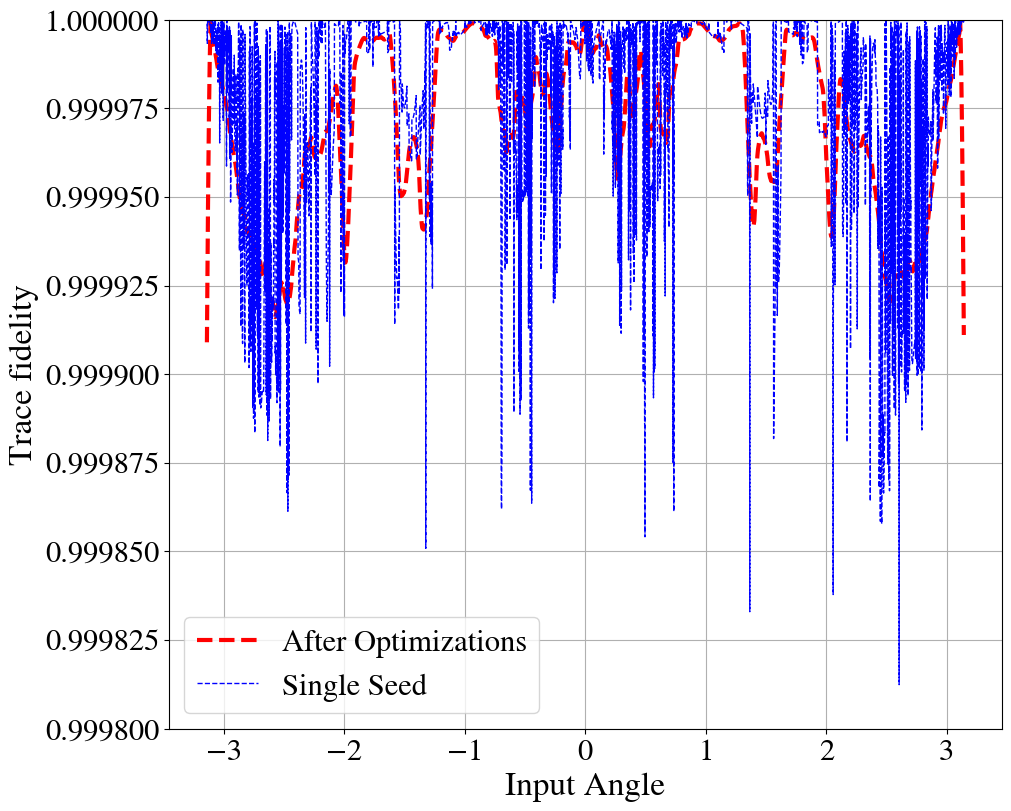

In [10]:
from matplotlib.ticker import ScalarFormatter

# Create 'plots' directory if it doesn't exist
if not os.path.exists('plots'):
    os.makedirs('plots')

n_resolution = len(fidelities_list[0])
label_list = ['After Optimizations', 'Single Seed']

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 8), constrained_layout=True)

# Increase line width and adjust line style
line_style_list = ['--r', '--b']
line_width = 3  # Adjust line width as needed

# Customize plot
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))  # Turn off scientific notation for y-axis
ax.set_ylim([0.9998, 1])  # Adjust y-axis limit if needed
ax.set_xlabel('Input Angle', fontsize=24)
ax.set_ylabel('Trace fidelity', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.grid(True)  # Add grid lines


for fidelities, angles, ls, lb in zip(fidelities_list, angles_list, line_style_list, label_list):
    angle_ids = np.array(np.rint((angles + np.pi) / (2. * np.pi) * (n_resolution - 1)), dtype=int)
    f_aver_list = np.zeros(n_resolution)
    counter_list = np.zeros(n_resolution)
    for angle_id, f in zip(angle_ids, fidelities):
        f_aver_list[angle_id] += f
        counter_list[angle_id] += 1
    f_aver_list = f_aver_list / counter_list
    
    ax.plot(np.linspace(-np.pi, np.pi, n_resolution), f_aver_list, ls, linewidth=line_width, label=lb,)  # Use the linewidth
    line_width = line_width-2

ax.legend(fontsize=22, ncol=1, loc='best')  # Adjust legend
plt.savefig('plots/fidelity_compare.png')
plt.show()

Empty plot indicates no bad fidelity predictions: